In [1]:
import numpy as np
import scipy as sp
import suite2p as s2p
import TwoPUtils as tpu
import InVivoDA_analyses as da
import STX3KO_analyses as stx
import os
import shutil

import sbxreader

%matplotlib inline

%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [2]:
# from InVivoDA_analyses.path_dict_esay import path_dictionary as path_dict
from STX3KO_analyses.path_dicts.path_dict_esay import path_dictionary as path_dict

# options: path_dict_josquin, path_dict_msosamac, etc.
path_dict

{'preprocessed_root': 'C://Users\\esay\\data\\Stx3',
 'pkl_root': 'C://Users\\esay\\data\\Stx3\\YMazeSessPkls',
 'sbx_root': 'Z://giocomo\\InVivoDA\\2P_Data',
 'VR_Data': 'C://Users\\esay\\data\\Stx3\\VR_Data',
 'git_repo_root': 'C://repos',
 'TwoPUtils': 'C://repos\\TwoPUtils',
 'home': 'C://',
 'fig_dir': 'C://Users\\esay\\data\\Stx3\\fig_scratch'}

In [3]:
mouse = "SparseKO_02"
basedir = os.path.join(path_dict['preprocessed_root'],mouse) #"/mnt/BigDisk/2P_scratch/GRABDA15"
sbxdir = os.path.join(path_dict['sbx_root'],mouse) 

custom_nplanes = 1 # if needed to override empty optotune params

basedir, sbxdir

('C://Users\\esay\\data\\Stx3\\SparseKO_02',
 'Z://giocomo\\InVivoDA\\2P_Data\\SparseKO_02')

In [23]:
file_list = stx.ymaze_sess_deets.SparseKO_sessions[mouse]

file_list = [file_list[3]]
file_list

[{'date': '19_11_2024',
  'scene': 'YMaze_LNovel',
  'session': 1,
  'scan': 4,
  'novel_arm': -1,
  'exp_day': 4}]

In [24]:
for fn,f in enumerate(file_list):
# f = file_list

    # Set data input and output paths
    fullpath = os.path.join(basedir,f['date'],f['scene'],"%s_%03d_%03d" % (f['scene'], f['session'], f['scan']))
    scanpath = os.path.join(sbxdir,f['date'],f['scene'],"%s_%03d_%03d" % (f['scene'], f['session'], f['scan']))
    h5path = os.path.join(basedir,f['date'],f['scene'],"%s_%03d_%03d.h5" % (f['scene'], f['session'], f['scan']))

    # load .mat header with metadata
    scanmat, sbxfile = scanpath+'.mat', scanpath+'.sbx'
    info = tpu.scanner_tools.sbx_utils.loadmat(scanmat, sbx_version=3)

    if len(info['etl_table'])>0:
        nplanes = info['etl_table'].shape[0]
    else:
        nplanes = custom_nplanes
        print('"etl_table" was empty; hardcoding %d planes' % nplanes)

    print('nplanes=',nplanes)

    print('pockmux:', info['pockmux'])
    # convert .sbx file to .h5
    # h5name = tpu.scanner_tools.sbx_utils.sbx2h5_cutdb_pockmux(scanpath, output_name=h5path, sbx_version=3) #, force_2chan=True)
    h5name = tpu.scanner_tools.sbx_utils.sbx2h5(scanpath,output_name=h5path, sbx_version=3) #, force_2chan=True)

    # run suite2p to run motion registration AND extract ROIs on the first
    # functional channel (channel 1, green, PMT0)
    ops = tpu.s2p.set_ops(d={'data_path': [os.path.split(fullpath)[0]],
                           'save_path0': fullpath,
                           'fast_disk':[],
                           'move_bin':True,
                           'two_step_registration':True,
                           'maxregshiftNR':10,
                           'nchannels':2,
                           'tau': 0.7,
                           'functional_chan':1,
                            'align_by_chan' : 1,
                           'nimg_init': 2000,
                           'fs':info['frame_rate'],
                           'roidetect':True,
                           'input_format':"h5", #h5
                           'h5py_key':'data',
                           'sparse_mode':True,
                           'threshold_scaling':.8, #.6
                            'sbx_ndeadcols': 100,
                            'nplanes':nplanes})
    
    ops=s2p.run_s2p(ops=ops)

    # !rm {h5name} 

"etl_table" was empty; hardcoding 1 planes
nplanes= 1
pockmux: 1
dset size <HDF5 dataset "data": shape (75524, 512, 796), type "<f4">
0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
20000 21000
21000 22000
22000 23000
23000 24000
24000 25000
25000 26000
26000 27000
27000 28000
28000 29000
29000 30000
30000 31000
31000 32000
32000 33000
33000 34000
34000 35000
35000 36000
36000 37000
37000 38000
38000 39000
39000 40000
40000 41000
41000 42000
42000 43000
43000 44000
44000 45000
45000 46000
46000 47000
47000 48000
48000 49000
49000 50000
50000 51000
51000 52000
52000 53000
53000 54000
54000 55000
55000 56000
56000 57000
57000 58000
58000 59000
59000 60000
60000 61000
61000 62000
62000 63000
63000 64000
64000 65000
65000 66000
66000 67000
67000 68000
68000 69000
69000 70000
70000 71000
71000 72000
72000 73000
73000 74000


ValueError: cannot mmap an empty file

In [18]:
## Use the existing motion-registered binary and
# extract ROIs for functional channel 2 (red, PMT1)
ops_orig = ops.copy()

In [19]:
ops = ops_orig.copy()
save_path_orig = ops_orig['save_path0']
ops['save_path0'] = os.path.join(save_path_orig,'chan2')
ops['save_path'] = os.path.join(ops['save_path0'], 'suite2p', 'plane0')
os.makedirs(ops['save_path'], exist_ok=True)


In [20]:
ops['functional_chan'] = 2
ops['align_by_chan'] = 1
# get rid of refImg so it re-runs registration in the new channel
del ops['refImg']
ops['do_registration'] = 1

In [21]:
## currently this will extract and re-register a new binary from the same .h5 file (which is redundant)
opsEnd=s2p.run_s2p(ops=ops)

{}
h5
OPS1 h5py: []
Could not find any h5 files


Exception: no h5s

In [ ]:
# optional delete binary and h5 
print('Deleting reg file')
!del {ops['reg_file']}
!del {ops['reg_file_chan2']} 
print('Deleting h5 file')
!del {h5name} 

## Copying binaries function written into for loop

In [65]:
for fn,f in enumerate(file_list):

    # Set data input and output paths
    fullpath = os.path.join(basedir,f['date'],f['scene'],"%s_%03d_%03d" % (f['scene'], f['session'], f['scan']))
    scanpath = os.path.join(sbxdir,f['date'],f['scene'],"%s_%03d_%03d" % (f['scene'], f['session'], f['scan']))
    h5path = os.path.join(basedir,f['date'],f['scene'],"%s_%03d_%03d.h5" % (f['scene'], f['session'], f['scan']))
    # fullpath = os.path.join(basedir,f[fn]['date'],f[fn]['scene'],"%s_%03d_%03d" % (f[fn]['scene'], f[fn]['session'], f[fn]['scan']))
    # scanpath = os.path.join(sbxdir,f[fn]['date'],f[fn]['scene'],"%s_%03d_%03d" % (f[fn]['scene'], f[fn]['session'], f[fn]['scan']))
    # h5path = os.path.join(basedir,f[fn]['date'],f[fn]['scene'],"%s_%03d_%03d.h5" % (f[fn]['scene'], f[fn]['session'], f[fn]['scan']))

    # load .mat header with metadata
    scanmat, sbxfile = scanpath+'.mat', scanpath+'.sbx'
    info = tpu.scanner_tools.sbx_utils.loadmat(scanmat, sbx_version=3)
    if len(info['etl_table'])>0:
        nplanes = info['etl_table'].shape[0]
    else:
        nplanes = custom_nplanes
        print('"etl_table" was empty; hardcoding %d planes' % nplanes)

    print('nplanes=',nplanes)

    # convert .sbx file to .h5
    # h5name = tpu.scanner_tools.sbx_utils.sbx2h5(scanpath,output_name=h5path, sbx_version=3)
    h5name = tpu.scanner_tools.sbx_utils.sbx2h5_cutdb_pockmux(scanpath,output_name=h5path, sbx_version=3)

    
    # run suite2p to run motion registration AND extract ROIs on the first
    # functional channel (channel 1, green, PMT0)
    ops_orig = tpu.s2p.set_ops(d={'data_path': [os.path.split(fullpath)[0]],
                           'save_path0': fullpath,
                           'fast_disk':[],
                           'move_bin':False,
                           'two_step_registration':True,
                           'maxregshiftNR':10,
                           'nchannels':2,
                           'tau': 0.7,
                           'functional_chan':1,
                           'nimg_init': 2000,
                           'fs':info['frame_rate'],
                           'roidetect':True,
                           'input_format':"h5",
                           'h5py_key':'data',
                           'sparse_mode':True,
                           'threshold_scaling':.6, #.6,
                            'sbx_ndeadcols': 100,
                            'nplanes':nplanes})

    ops_orig=s2p.run_s2p(ops=ops_orig)

    # copy binary
    tpu.scanner_tools.sbx_utils.copy_bin(ops_orig)

    ## Optional: update ROI threshold for the second channel
    ops['threshold_scaling'] = .85
    print("Updated threshold scaling to",ops['threshold_scaling'])
    
    ## Run the ROI extraction for the second channel
    print('Running ROI extraction for second channel')
    opsEnd=s2p.run_s2p(ops=ops)
    ## OPTIONAL delete copied binaries from the chan2 path to save disk space

    print('Deleting reg file')
    !del {ops['reg_file']}
    !del {ops['reg_file_chan2']} 
    print('Deleting h5 file')
    !del {h5name} 
    

"etl_table" was empty; hardcoding 1 planes
nplanes= 1
num dead cols and rows: 100 0
within func pockmux= 1
write batch size: 500
dset size <HDF5 dataset "data": shape (75524, 512, 696), type "<f4">
0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
20000 21000
21000 22000
22000 23000
23000 24000
24000 25000
25000 26000
26000 27000
27000 28000
28000 29000
29000 30000
30000 31000
31000 32000
32000 33000
33000 34000
34000 35000
35000 36000
36000 37000
37000 38000
38000 39000
39000 40000
40000 41000
41000 42000
42000 43000
43000 44000
44000 45000
45000 46000
46000 47000
47000 48000
48000 49000
49000 50000
50000 51000
51000 52000
52000 53000
53000 54000
54000 55000
55000 56000
56000 57000
57000 58000
58000 59000
59000 60000
60000 61000
61000 62000
62000 63000
63000 64000
64000 65000
65000 66000
66000 67000
67000 68000
68000 69

Could Not Find C:\Users\esay\data\Stx3\SparseKO_02\18_11_2024\YMaze_LNovel\YMaze_LNovel_001_018\suite2p\plane0\data.bin


Deleting h5 file


Could Not Find C:\Users\esay\data\Stx3\SparseKO_02\18_11_2024\YMaze_LNovel\YMaze_LNovel_001_018\suite2p\plane0\data_chan2.bin


In [15]:
import shutil
tpu.scanner_tools.sbx_utils.copy_bin(ops_orig)


Copying binary


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\esay\\data\\Stx3\\SparseKO_02\\16_11_2024\\YMaze_LNovel\\YMaze_LNovel_004_014\\suite2p\\plane0\\data_chan2.bin'

In [10]:
import shutil
# copy binary
print("Copying binary")
ops = ops_orig.copy()
save_path_orig = ops_orig['save_path0']

    # Make new save path, destination for new ops, stat, and copied binaries
ops['save_path'] = os.path.join(ops['save_path0'], 'chan2','suite2p', 'plane0')
os.makedirs(ops['save_path'], exist_ok=True)

    
ops['fast_disk'] = [] # remove this so there's no confusion with save_path
    
orig_reg_file_1 = os.path.join(save_path_orig,'suite2p','plane0','data.bin') # the original data.nbin
orig_reg_file_2 = os.path.join(save_path_orig,'suite2p','plane0','data_chan2.bin') # the original data_chan2.nbin
    
    # switch meanImg <-> meanImg_chan2
mimg = np.copy(ops_orig['meanImg'])
ops['meanImg'] = np.copy(ops_orig['meanImg_chan2'])
ops['meanImg_chan2'] = mimg
    
    # copy chan2 reg file (original data_chan2.bin) to new location as "data.bin"
ops['reg_file'] = os.path.join(ops['save_path'], 'data.bin') # create a path for the new reg_file
shutil.copyfile(orig_reg_file_2, ops['reg_file'])
print('red reg_file_chan2 copied to %s'%(ops['reg_file']))
    
    # now copy original chan1 reg file to new "data_chan2.bin"
ops['reg_file_chan2'] = os.path.join(ops['save_path'], 'data_chan2.bin') # create a path for the new chan2 reg_file
shutil.copyfile(orig_reg_file_1, ops['reg_file_chan2'])
print('green reg_file copied to %s'%(ops['reg_file_chan2']))

    # save new ops file with paths
ops['ops_path'] = os.path.join(ops['save_path'],'ops.npy')
ops['save_path0'] = os.path.join(ops['save_path0'], 'chan2') # need it to look here + suite2p/plane0/ for binaries that we copied
    
np.save(ops['ops_path'], ops)

    ## Optional: update ROI threshold for the second channel
ops['threshold_scaling'] = .85
print("Updated threshold scaling to",ops['threshold_scaling'])
    
    ## Run the ROI extraction for the second channel
print('Running ROI extraction for second channel')
opsEnd=s2p.run_s2p(ops=ops)
    ## OPTIONAL delete copied binaries from the chan2 path to save disk space

print('Deleting reg file')
!del {ops['reg_file']}
!del {ops['reg_file_chan2']} 
print('Deleting h5 file')
!del {h5name} 

Copying binary
red reg_file_chan2 copied to C:\Users\esay\data\Stx3\SparseKO_02\16_11_2024\YMaze_LNovel\YMaze_LNovel_004_014\chan2\suite2p\plane0\data.bin
green reg_file copied to C:\Users\esay\data\Stx3\SparseKO_02\16_11_2024\YMaze_LNovel\YMaze_LNovel_004_014\chan2\suite2p\plane0\data_chan2.bin
Updated threshold scaling to 0.85
Running ROI extraction for second channel
{}
FOUND BINARIES AND OPS IN ['C:\\Users\\esay\\data\\Stx3\\SparseKO_02\\16_11_2024\\YMaze_LNovel\\YMaze_LNovel_004_014\\chan2\\suite2p\\plane0\\ops.npy']
removing previous detection and extraction files, if present
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, plane already registered
binary path: C:\Users\esay\data\Stx3\SparseKO_02\16_11_2024\YMaze_LNovel\YMaze_LNovel_004_014\chan2\suite2p\plane0\data.bin
NOTE: applying default C:\Users\esay\.suite2p\classifiers\classifier_user.npy
----------- ROI DETECTION
Binning movie in chunks of length 22
Binned movie of size [1770,488,750] 

C:\Users\esay\.conda\envs\es_base\lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_locatio

>>>> 404 masks detected, median diameter = 15.33 
----------- Total 96.08 sec.
----------- EXTRACTION
Masks created, 0.57 sec.
Extracted fluorescence from 174 ROIs in 38949 frames, 38.72 sec.
Extracted fluorescence from 174 ROIs in 38949 frames, 43.30 sec.
----------- Total 82.90 sec.
----------- CLASSIFICATION
['compact', 'npix_norm', 'skew']
----------- SPIKE DECONVOLUTION
----------- Total 0.19 sec.
Plane 0 processed in 179.25 sec (can open in GUI).
total = 184.51 sec.
TOTAL RUNTIME 184.51 sec
Deleting reg file
Deleting h5 file


## Below here was our attempt to use Carsen Stringer's method of copying the reg_files

In [12]:
### SETUP FOR RUNNING ONLY CELL DETECTION ON SECOND CHANNEL
import shutil

# grab fast_disk variable if it is user-specified
if 'fast_disk' in ops_orig and len(ops_orig['fast_disk'])>0:
    fast_disk = ops_orig['fast_disk']
else:
    fast_disk = []
# grab save_path0
save_path_orig = ops_orig['save_path0']
# make a new folder for channel 2 save files and binary files
ops1 = []
j=0
# for ops in opsEnd:
ops = ops_orig.copy()
# make a chan2 folder inside the save path
ops['save_path0'] = os.path.join(save_path_orig,'chan2')
ops['save_path'] = os.path.join(ops['save_path0'], 'suite2p', 'plane%d'%j)
os.makedirs(ops['save_path'], exist_ok=True)
# ops['ops_path'] = os.path.join(ops['save_path'],'ops.npy')
# put binary file there or in user-specified + chan2
if len(fast_disk)==0:
    fast_disk0 = os.path.join(ops['save_path0'])
else:
    fast_disk0 = os.path.join(fast_disk,'chan2')
ops['fast_disk'] = os.path.join(fast_disk0, 'suite2p', 'plane%d'%j)
os.makedirs(ops['fast_disk'], exist_ok=True)

In [13]:
ops['reg_file'] = os.path.join(ops['fast_disk'], 'data.bin') # create a path for the new reg_file
orig_reg_file = os.path.join(save_path_orig,'suite2p','plane0','data.bin') # the original data.nbin

# switch meanImg <-> meanImg_chan2
mimg = np.copy(ops_orig['meanImg'])
ops['meanImg'] = np.copy(ops_orig['meanImg_chan2'])
ops['meanImg_chan2'] = mimg
# copy chan2 reg file (doriginal data_chan2.bin) to new location
shutil.copyfile(ops['reg_file_chan2'], ops['reg_file'])
print('reg_file_chan2 copied to %s'%(ops['reg_file']))

# now copy original chan1 data to new "chan2"
ops['reg_file_chan2'] = os.path.join(ops['fast_disk'], 'data_chan2.bin') # create a path for the new chan2 reg_file
shutil.copyfile(orig_reg_file, ops['reg_file_chan2'])
print('reg_file copied to %s'%(ops['reg_file_chan2']))

# save new ops file with paths
ops['ops_path'] = os.path.join(ops['fast_disk'],'ops.npy')
np.save(ops['ops_path'], ops)
ops1.append(ops.copy())
j+=1
# save ops across planes in new location
# np.save(os.path.join(ops1[0]['save_path0'],'suite2p','ops1.npy'), ops1)

reg_file_chan2 copied to /data/2P/SparseKO_05/01_11_2024/twolasers_noMux/twolasers_noMux_000_000/suite2p/plane0/chan2/suite2p/plane0/data.bin
reg_file copied to /data/2P/SparseKO_05/01_11_2024/twolasers_noMux/twolasers_noMux_000_000/suite2p/plane0/chan2/suite2p/plane0/data_chan2.bin


In [24]:
ops['fast_disk']

'/data/2P/SparseKO_05/30_10_2024/RunningTraining_scan/RunningTraining_scan_002_003/suite2p/plane0/chan2/suite2p/plane0'

In [22]:
ops['save_path']

'/data/2P/SparseKO_05/01_11_2024/twolasers_noMux/twolasers_noMux_000_000/chan2/suite2p/plane0'

In [39]:
import matplotlib.pyplot as plt

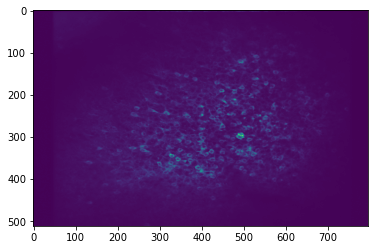

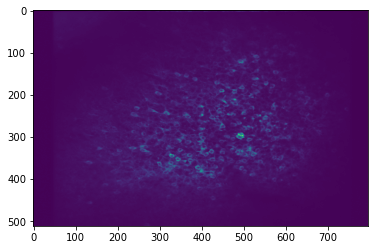

In [14]:
plt.figure()
plt.imshow(ops_orig['meanImg_chan2'])

plt.figure()
plt.imshow(ops['meanImg'])

In [16]:
# run pipeline on second channel 
# (will skip registration b/c binary file exists)
ops_to_run = ops1[0].copy()
ops_to_run['functional_chan'] = 1
del ops_to_run['save_path']
del ops_to_run['ops_path']
# del ops0['reg_file']
# del ops0['reg_file_chan2']

# we want to get the data on chan1 for the chan2 ROIs as well so we can measure crosstalk?

# opsEnd=run_s2p(ops=ops0,db=db)
opsEnd=s2p.run_s2p(ops=ops_to_run)

{}
FOUND BINARIES AND OPS IN ['/data/2P/SparseKO_05/01_11_2024/twolasers_noMux/twolasers_noMux_000_000/chan2/suite2p/plane0/ops.npy']
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, plane already registered
binary path: /data/2P/SparseKO_05/01_11_2024/twolasers_noMux/twolasers_noMux_000_000/chan2/suite2p/plane0/data.bin
NOTE: applying default /home/mari/.suite2p/classifiers/classifier_user.npy
----------- ROI DETECTION
Binning movie in chunks of length 11
Binned movie [135,510,784] in 1.64 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, threshold 3.00 
0 ROIs, score=39.45
1000 ROIs, score=4.60
2000 ROIs, score=4.09
3000 ROIs, score=3.82
4000 ROIs, score=3.68
Detected 5000 ROIs, 13.86 sec
After removing overlaps, 4801 ROIs remain


cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


>>>> CELLPOSE estimating masks in anatomical channel
>>>> 94 masks detected, median diameter = 14.34 
ERROR importing or running cellpose, continuing without anatomical estimates
----------- Total 39.47 sec.
----------- EXTRACTION
Masks created, 4.32 sec.
Extracted fluorescence from 4801 ROIs in 1850 frames, 4.59 sec.
Extracted fluorescence from 4801 ROIs in 1850 frames, 4.67 sec.
----------- Total 14.04 sec.
----------- CLASSIFICATION
['compact', 'npix_norm', 'skew']
----------- Total 0.02 sec.
----------- SPIKE DECONVOLUTION
----------- Total 0.42 sec.
moving binary files to save_path
Plane 0 processed in 53.97 sec (can open in GUI).
total = 54.14 sec.
TOTAL RUNTIME 54.14 sec


In [24]:
scanpath

'/data/2P/SparseKO_05/01_11_2024/twolasers_Mux/twolasers_Mux_000_001'

### Plotting each FOV with the "dead columns" from the bidirectional scanning cut off

In [36]:
x = tpu.scanner_tools.sbx_utils.sbxread(scanpath, N=100, sbx_version=3)

In [46]:
x[:,:,:,::2].shape

(2, 796, 512, 50)

In [43]:
ndeadcols = tpu.scanner_tools.sbx_utils.find_deadbands(scanpath)
ndeadcols

76

In [48]:
np.arange(0,11)[::2], np.arange(0,11)[1::2]

(array([ 0,  2,  4,  6,  8, 10]), array([1, 3, 5, 7, 9]))

1999.305399999998


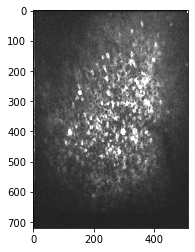

In [85]:
plt.figure()
data_chan1 = x[0,ndeadcols:,:,::2]
vmax = np.percentile(np.nanmean(data_chan1,axis=2).ravel(), 99)
print(vmax)
plt.imshow(np.nanmean(data_chan1,axis=2), cmap='Greys_r', vmax = vmax)

530.4443999999994


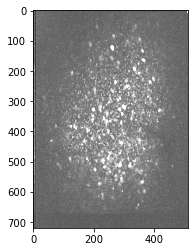

In [87]:
plt.figure()
data_chan2 = x[1,ndeadcols:,:,1::2]
vmax = np.percentile(np.nanmean(data_chan2,axis=2).ravel(), 99)
print(vmax)
plt.imshow(np.nanmean(data_chan2,axis=2), cmap='Greys_r', vmax = vmax)